In [1]:
print('Hello Python')

import os
import cv2
import imghdr
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Model building

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import HeNormal

Hello Python


C:\Users\AMIT\AppData\Local\Temp\ipykernel_11912\3648800834.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Num GPUs Available:  0


# Image Augmentation

In [2]:
# define the train and test path of dataset
train_path = r"C:\Users\AMIT\Hardik M\Projects\Emotion Detection Using CNN\archive\train"
test_path = r"C:\Users\AMIT\Hardik M\Projects\Emotion Detection Using CNN\archive\test"

# set parameters
img_width, img_height = 48, 48
batch_size= 32
num_classes = 7

In [3]:
# Initialize ImageDataGenerator with data augmentation option for training set
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)

# Automaticly recieve images and classes for train and test set
train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

val_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


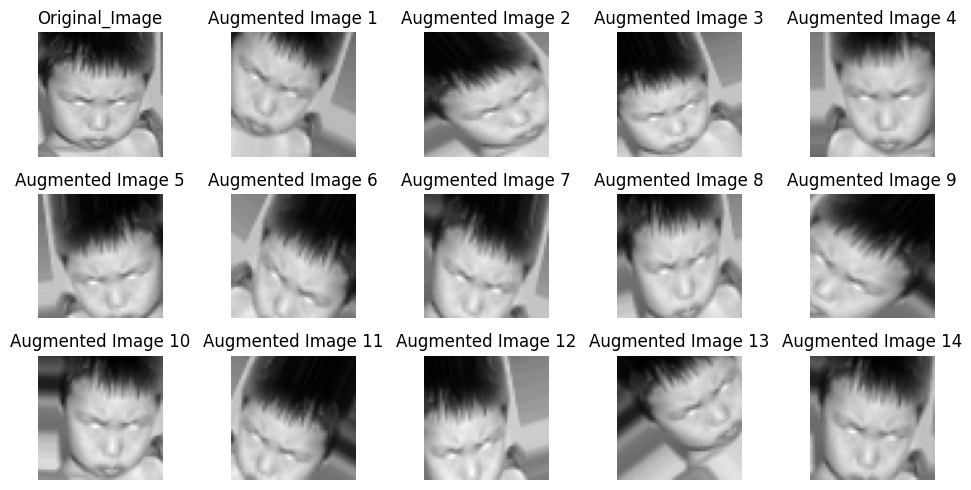

In [4]:
# Path to your specific image
image_path = r"C:\Users\AMIT\Hardik M\Projects\Emotion Detection Using CNN\archive\train\angry\Training_10118481.jpg"

# load image from image_path
image = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
image_arr = img_to_array(image)

# reshape the image into (batchsize, wid, heig, chennal)
image_arr = image_arr.reshape((1, ) + image_arr.shape)

# Setting up plot for augmented image
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
axes = axes.flat
# Plot the original image first. Since img_array is a 3D array after reshaping, 
axes[0].imshow(image_arr[0], cmap='gray')
axes[0].set_title("Original_Image")
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes[1:]):
    # Generate batch of augmented image
    aug_iter = train_data_generator.flow(image_arr, batch_size=1)
    aug_image = next(aug_iter)[0] # Get the first augmented image from the batch

    # Plot the augmented image.
    ax.imshow(aug_image, cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# CNN Model

In [5]:
# model = Sequential()
# # x = ( (width-kernel(x) + 2*p(1)) / s ) + 1, y = () + 1

# model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', 
#                 kernel_regularizer=L2(0.01),
#                  kernel_initializer=HeNormal() , input_shape=(img_width, img_height, 1)))
# # x = (48-3+2*1) / 1 + 1 = 48
# # y = (48-3+2*1) / 1 + 1 = 48
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
# # x = (48-2+2*0) / 2 + 1 = 24
# # y = (48-2+2*0) / 2 + 1 = 24

# model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=L2(0.01),
#                  kernel_initializer=HeNormal()))
# # x = (24-3+2*1) / 1 + 1 = 24
# # y = (24-3+2*1) / 1 + 1 = 24
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
# # x = (24-2+2*0) / 2 + 1 = 12
# # y = (24-2+2*0) / 2 + 1 = 12

# model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=L2(0.01),
#                  kernel_initializer=HeNormal()))
# # x = (12-3+2*1) / 1 + 1 = 12
# # y = (12-3+2*1) / 1 + 1 = 12
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
# # x = (12-2+2*0) / 2 + 1 = 6
# # y = (12-2+2*0) / 2 + 1 = 6

# model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=L2(0.01),
#                  kernel_initializer=HeNormal()))
# # x = (6-3+2*1) / 1 + 1 = 6
# # y = (6-3+2*1) / 1 + 1 = 6
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
# # x = (6-2+2*0) / 2 + 1 = 3
# # y = (6-2+2*0) / 2 + 1 = 3

# model.add(Flatten())

# model.add(Dense(units=128))
# model.add(Activation('relu'))
# model.add(Dropout(rate=0.3))

# model.add(Dense(units=64))
# model.add(Activation('relu'))
# model.add(Dropout(rate=0.3))

# model.add(Dense(units=32))
# model.add(Activation('relu'))

# model.add(Dense(units=num_classes))
# model.add(Activation('softmax'))

In [6]:
# model = Sequential()

# model.add(Conv2D
#           (filters=32, kernel_size=(3, 3), kernel_initializer=HeNormal(),
#            strides=(1, 1), padding='same', input_shape=(img_width, img_height, 1)))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=HeNormal() ,strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=HeNormal(), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=HeNormal(), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=HeNormal(), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=HeNormal(), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))


# model.add(Flatten())
# model.add(Dense(units=128))
# model.add(Activation('relu'))
# model.add(Dropout(rate=0.25))

# model.add(Dense(units=64))
# model.add(Activation('relu'))
# model.add(Dropout(rate=0.25))

# model.add(Dense(units=32))
# model.add(Activation('relu'))

# model.add(Dense(units=num_classes))
# model.add(Activation('softmax'))

In [9]:
# model = Sequential()

# model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(rate=0.25))

# model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(3, 3)))
# model.add(Dropout(rate=0.25))


# model.add(Flatten())
# model.add(Dense(units=128))
# model.add(Activation('relu'))
# model.add(Dense(units=64))
# model.add(Activation('relu'))
# model.add(Dense(units=32))
# model.add(Activation('relu'))

# model.add(Dense(units=num_classes))
# model.add(Activation('softmax'))

In [6]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.25))


model.add(Flatten())
model.add(Dense(units=128))
model.add(Activation('relu'))
model.add(Dense(units=64))
model.add(Activation('relu'))
model.add(Dense(units=32))
model.add(Activation('relu'))

model.add(Dense(units=num_classes))
model.add(Activation('softmax'))

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │              

 Total params: 560,167 (2.14 MB)

 Trainable params: 559,719 (2.14 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Setting up Checkpoints 

# file path for the model checkpoints
cnn_path = r'C:\Users\AMIT\Hardik M\Projects\Emotion Detection Using CNN\Emotion_Detection\CNN_with_Augmentation'
name = 'CNN_with_Augmentation.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'C:\\Users\\AMIT\\Hardik M\\Projects\\Emotion Detection Using CNN\\Emotion_Detection\\CNN_with_Augmentation\\CNN_with_Augmentation.keras'

In [9]:
# callback to save model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path, save_best_only=True, verbose=1, mode='min', monitor='val_loss')

# callback for EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)

# callback to reduce learning rate
reduceLRplt = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)

# callback to all log training data to a csv file
csvlogger = CSVLogger(os.path.join(cnn_path, 'AdvancedCNNTrainig.log'))

callbacks = [checkpoint, earlystopping, reduceLRplt, csvlogger]

In [10]:
# steps 
print(train_generator.samples)
train_steps_per_epoch = train_generator.samples // train_generator.batch_size +1
validation_steps_per_epoch = val_generator.samples // train_generator.batch_size 
test_steps_epoch = test_generator.samples // test_generator.batch_size 
print(train_steps_per_epoch)
print(validation_steps_per_epoch)
print(test_steps_epoch)

22968
718
179
224


In [11]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Model training

with tf.device("/GPU:0"):
    history = model.fit(train_generator,
                        epochs=20,
                        # initial_epoch=20,
                        validation_data=val_generator,
                        callbacks=callbacks)
    

Epoch 1/20


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.2243 - loss: 1.8606
Epoch 1: val_loss improved from inf to 1.78536, saving model to C:\Users\AMIT\Hardik M\Projects\Emotion Detection Using CNN\Emotion_Detection\CNN_with_Augmentation\CNN_with_Augmentation.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 673s 913ms/step - accuracy: 0.2244 - loss: 1.8605 - val_accuracy: 0.2571 - val_loss: 1.7854 - learning_rate: 0.0010
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.2561 - loss: 1.7804
Epoch 2: val_loss did not improve from 1.78536
718/718 ━━━━━━━━━━━━━━━━━━━━ 312s 432ms/step - accuracy: 0.2561 - loss: 1.7804 - val_accuracy: 0.2275 - val_loss: 1.8370 - learning_rate: 0.0010
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.2820 - loss: 1.7489
Epoch 3: val_loss did not improve from 1.78536
718/718 ━━━━━━━━━━━━━━━━━━━━ 200s 278ms/step - accuracy: 0.2820 - loss: 1.7489 - val_accuracy: 0.2205 - val_loss: 1.8033 - learning_rate: 0.0010
Epoch 4/20
718/718 ━━━━━━━

In [13]:
def plotting_training_history(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epoch_range = range(len(train_acc))

    plt.figure(figsize=(20, 5))

    # plot training and validation accuracy
    plt.subplot(1,2,1)
    plt.plot(epoch_range, train_acc, label='train_accuracy')
    plt.plot(epoch_range, val_acc, label='val_accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Plot')

    # plot training and validation loss
    plt.subplot(1,2,2)
    plt.plot(epoch_range, train_loss, label='train_loss')
    plt.plot(epoch_range, val_loss, label='val_loss')
    plt.legend()
    plt.title('Training and Validation Loss Plot')

    plt.show()

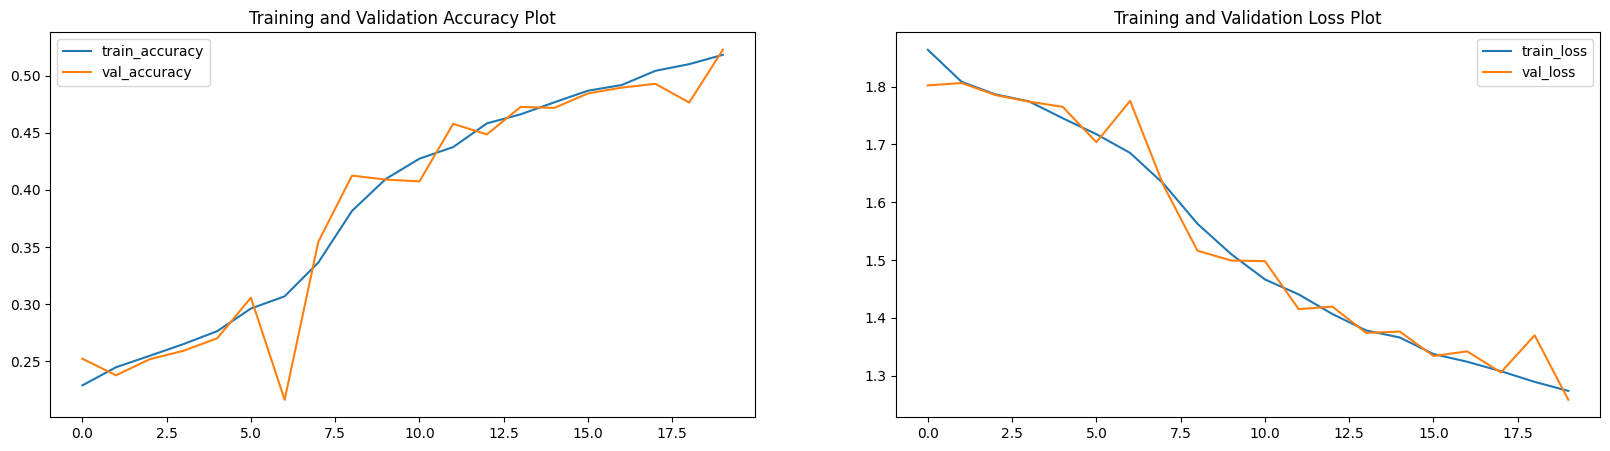

In [12]:
plotting_training_history(history)

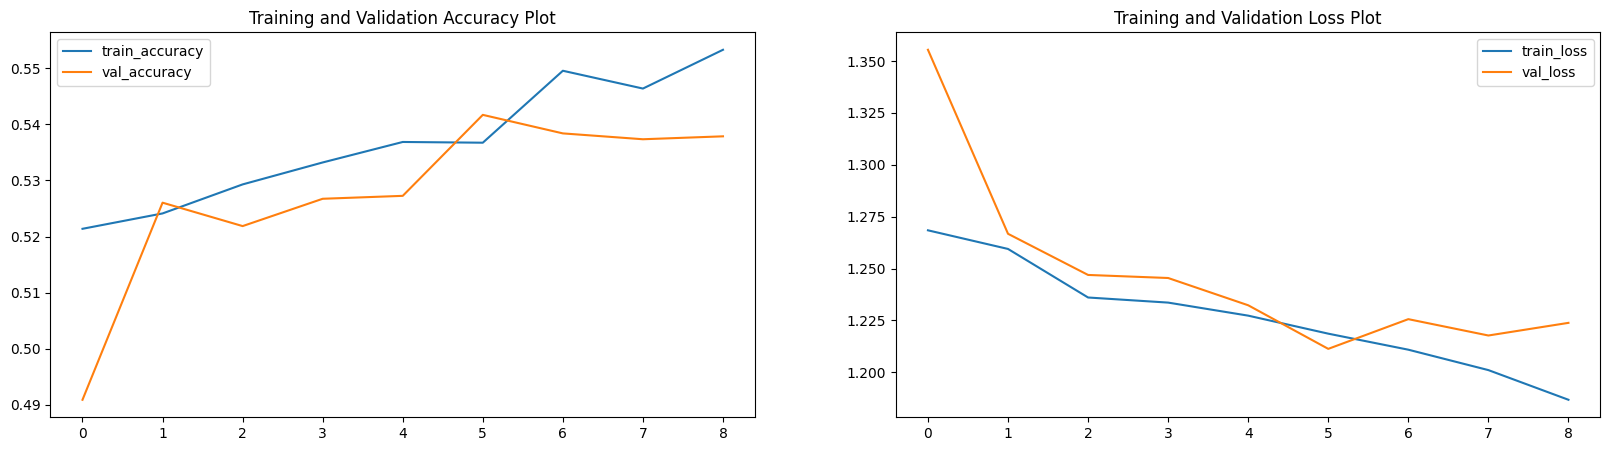

In [20]:
plotting_training_history(history)

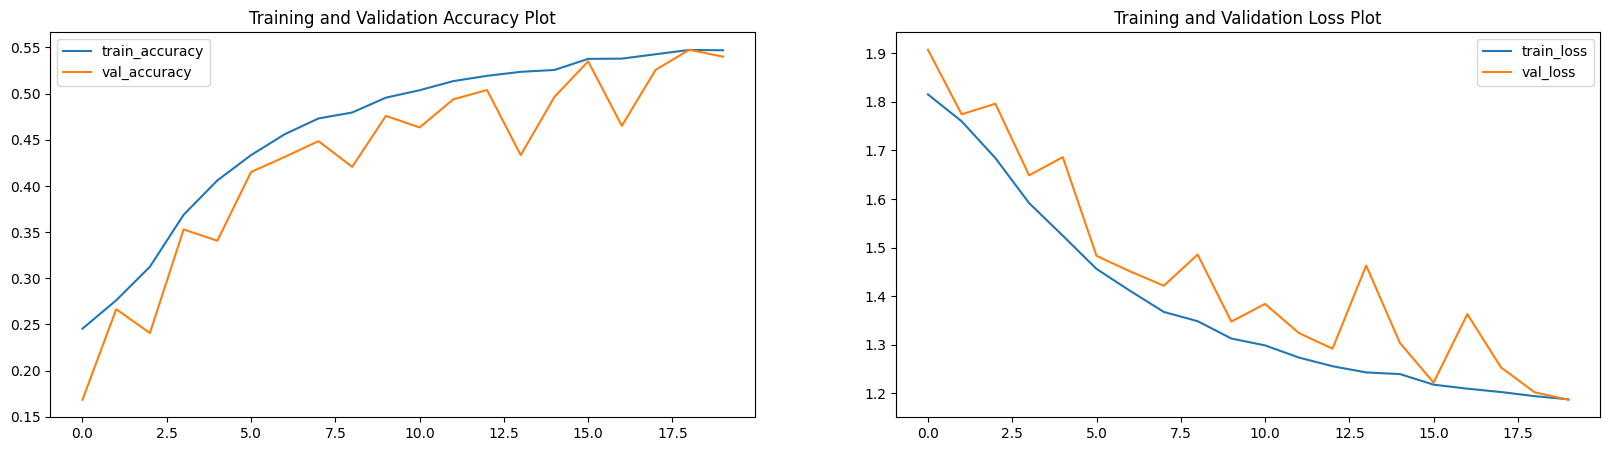

In [17]:
plotting_training_history(history)

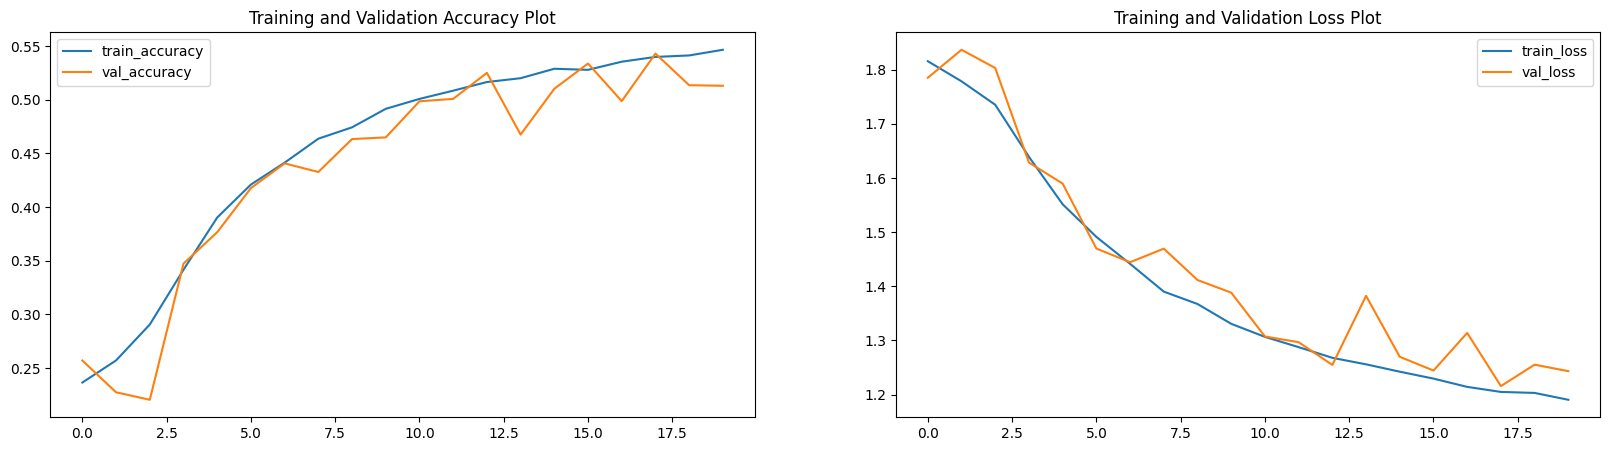

In [14]:
plotting_training_history(history)

In [15]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f"final train accuracy = {train_acc*100} , validation accuracy = {test_acc*100}")

718/718 ━━━━━━━━━━━━━━━━━━━━ 245s 341ms/step - accuracy: 0.5550 - loss: 1.1671
225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 420ms/step - accuracy: 0.5653 - loss: 1.1213
final train accuracy = 55.35092353820801 , validation accuracy = 57.06325173377991


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step


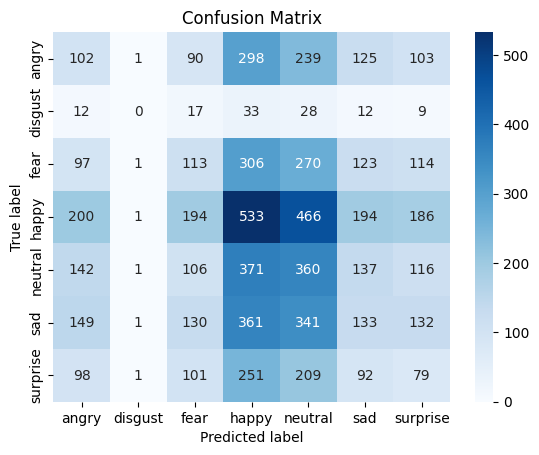

In [17]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size).astype('int')), axis=1)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
c_matrix = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
sns.heatmap(c_matrix, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
# generating classification_report
# Precision is defined as the ratio of correctly classified positive samples (True Positive) to a total number of classified positive samples 
# The recall measures the model's ability to detect positive samples.
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.13      0.11      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.11      0.13      1024
       happy       0.25      0.30      0.27      1774
     neutral       0.19      0.29      0.23      1233
         sad       0.16      0.11      0.13      1247
    surprise       0.11      0.10      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



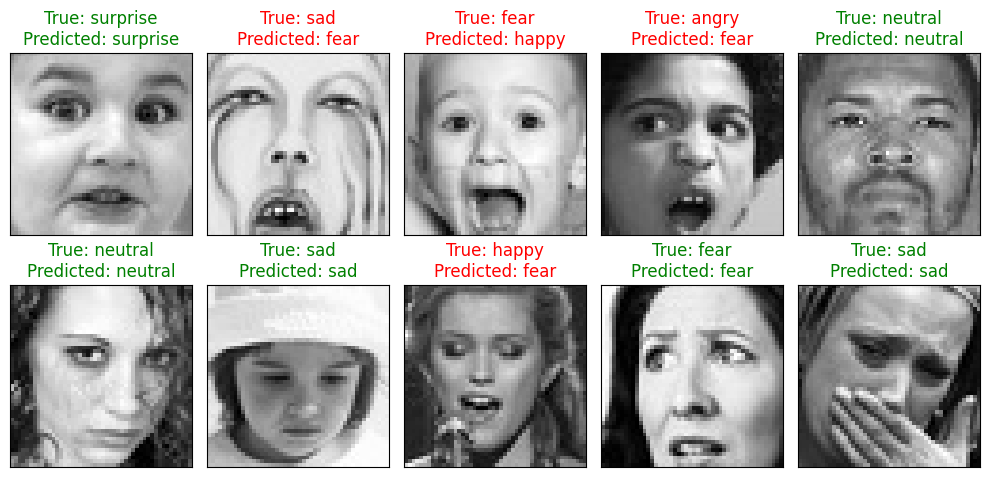

In [19]:
# Emotion classes for the dataset
emotion = class_labels

batch_size = test_generator.batch_size
# selection of random batch
random_batch = np.random.randint(0, len(test_generator)-1)
# selection of random image indices from batch_size
random_img_indices = np.random.randint(0, batch_size, 10)

# setting up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    random_image = test_generator[random_batch][0][random_img_indices[i]]
    random_image_label = np.argmax(test_generator[random_batch][1][random_img_indices[i]])

    # making prediction over random fatched image
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_image, axis=0), verbose=0))

    # display image
    ax.imshow(random_image.squeeze(), cmap='gray')
    # Setting the title with true and predicted labels, colored based on correctness
    color = 'green' if model_prediction == random_image_label else 'red'
    ax.set_title(f"True: {emotion[random_image_label]}\nPredicted: {emotion[model_prediction]}", color=color)

plt.tight_layout()
plt.show()